In [ ]:
# Baixem do meu github
!mkdir -p local_datasets
!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/__init__.py' -O 'local_datasets/__init__.py'
!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/datasets-7627-10826-banana.csv' -O 'local_datasets/datasets-7627-10826-banana.csv'
!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/rip.csv' -O 'local_datasets/rip.csv'


# importem o código assim
from local_datasets import load_banana, load_ripley, load_two_moon

bunch = load_ripley()
X, y = bunch.data, bunch.target
print(X.shape, y.shape)

(1249, 2) (1249,)


In [ ]:
import numpy as np

# MLP COM GRADIENTE


In [ ]:
def split_train_test(X,y,train_size):
  msk = np.random.rand(X.shape[0]) < train_size
  X_train = X[msk]
  y_train = y[msk]
  X_test = X[~msk]
  y_test = y[~msk]
  return X_train, y_train,X_test,y_test

In [ ]:
X_train, y_train, X_test, y_test = split_train_test(X,y,0.8)

In [ ]:
class NormPadronizacao:
  def __init__(self):
    self._colunas: dict = {}

  def normalizar(self, X):
    list_colunas_normalizadas = []
    for coluna in range(X.shape[1]):
      list_colunas_normalizadas.append((X[:,coluna] - self._colunas[f'media_{coluna}'])/self._colunas[f'desvio_padrao_{coluna}'])
    return np.array(list_colunas_normalizadas).T

  def treinar(self, X):
    for coluna in range(X.shape[1]):
      self._colunas[f'media_{coluna}'] = []
      self._colunas[f'desvio_padrao_{coluna}'] = []
      self._colunas[f'media_{coluna}'].append(np.mean(X[:,coluna]))
      self._colunas[f'desvio_padrao_{coluna}'].append(np.std(X[:,coluna]))
    print(self._colunas)

In [ ]:
Stdalizer = NormPadronizacao()
Stdalizer.treinar(X_train)

{'media_0': [-0.06616085129235236], 'desvio_padrao_0': [0.4830945329697738], 'media_1': [0.4906998508693126], 'desvio_padrao_1': [0.26113278194371664]}


In [ ]:
X_train = Stdalizer.normalizar(X_train)
X_test = Stdalizer.normalizar(X_test)

In [ ]:

import numpy as np

# funcao de custo e sua derivada
def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2);

def gradient(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;



In [ ]:
from abc import ABC, abstractmethod
class Layer(ABC):
    """Interface de uma camada a ser implementada."""
    def __init__(self):
        self.input = None
        self.output = None

    @abstractmethod
    def forward(self, input):
        raise NotImplementedError

    @abstractmethod
    def backward(self, output_error, learning_rate):
        raise NotImplementedError

In [ ]:
class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward(self, input_data):
        """Esta função ira fazer o produto de matrizes e adicionar o vetor i"""
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output


    def backward(self, output_error, learning_rate):
        """Esta função computa o gradiente e atualiza os pesos.

        Args:
            output_error : Erro já calculado com a derivada do MSE
            learning_rate: Taxa de aprendizagem

        Return:
            Erro do input em relação aos pesos da camada.
        """

        # Backtracking Line Search para encontrar o tamanho do passo
        # t = self.backtracking_line_search(x, gamma, grad)
        # x = x - t * grad
        error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        #
        self.weights = self.weights - learning_rate * weights_error
        self.bias = self.bias - learning_rate * output_error
        return error



In [ ]:
class SigmoidLayer(Layer):

    def forward(self, input_data):
        self.input = input_data
        self.output = self.__sigmoid(self.input)
        return self.output

    def backward(self, output_error, learning_rate):
        return self.__derivada_sigmoid(self.input) * output_error

    def __sigmoid(self, u):
        return 1/(1+np.exp(-u))

    def __derivada_sigmoid(self, u):
         local_sigmoid = self.__sigmoid(u)
         return local_sigmoid * (1-local_sigmoid)

In [ ]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
class MLP:
    def __init__(self):
        self.layers = []
        self.loss = []
    def add(self, layer):
        """Adiciona uma camada linear ao meu 'Sequential' de Camadas."""
        self.layers.append(layer)

    def predict(self, input_data):
        """Realiza a predição de um dado de entrada."""
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return np.array(result)
    def plot_loss_graph(self):
        plt.plot(self.loss)
        plt.savefig("loss_mlp_classic_two_moon", dpi=300)
        plt.show()

    def plot_decision_regions(self, X, y, classifier, resolution=0.02):
        # setando os marcadores para utilizarmos no grafico
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # plotando a superfície de decisão
        x1_min, x1_max = X[:,  0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
        arr_to_be_predicted = np.array([xx1.ravel(), xx2.ravel()]).T
        arr_to_be_predicted = arr_to_be_predicted.reshape(arr_to_be_predicted.shape[0], 1, arr_to_be_predicted.shape[1] )
        Z = classifier.predict(arr_to_be_predicted)
        Z = Z.reshape(Z.shape[0],Z.shape[2])

        print(xx1.shape)
        Z = Z[:,1].reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # plotando as classes das amostras.
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
            alpha=0.8, c=cmap(idx),
            marker=markers[idx], label=cl)
        plt.savefig("decision_surface_mlp_classic_two_moon", dpi=300)
        plt.show()

    def fit(self, x_train, y_train, epochs, learning_rate):
        """Treinamento"""
        samples = len(x_train)

        tqdm_bar = tqdm(range(epochs))
        for i in tqdm_bar:
            tqdm_bar.set_description(f"Epoch {i}")
            err = 0
            for j in range(samples): #Para cada amostra

                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward(output)


                err += mse(y_train[j], output)

                # calculando  o gradiente
                error = gradient(y_train[j], output)

                for layer in reversed(self.layers):
                    # print(error.shape)
                    error = layer.backward(error, learning_rate)

            # calcula a média de erro de todas as amostras
            err /= samples
            self.loss.append(err)
            tqdm_bar.set_postfix(loss=err)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1] )

Epoch 299: 100%|██████████| 300/300 [00:30<00:00,  9.68it/s, loss=0.0577]


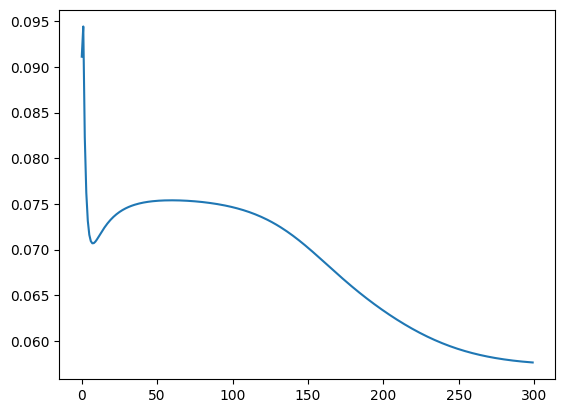

(287, 287)


<ipython-input-309-3a4388273da3>:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


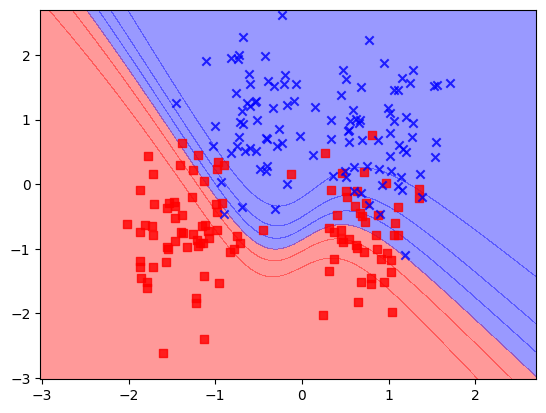

In [ ]:
net = MLP()
net.add(LinearLayer(X_train.shape[2], 64))
net.add(SigmoidLayer())
net.add(LinearLayer(64,2))
net.add(SigmoidLayer())

net.fit(X_train, y_train, epochs=300, learning_rate=0.01)

# test
out = net.predict(X_test)
net.plot_loss_graph()
net.plot_decision_regions(X_test, y_test, classifier=net)


# Metodo de newton


In [ ]:
class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward(self, input_data):
        """Esta função ira fazer o produto de matrizes e adicionar o vetor i"""
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output


    def backward(self, output_error, learning_rate):
        """Esta função computa o gradiente e atualiza os pesos.

        Args:
            output_error : Erro já calculado com a derivada do MSE
            learning_rate: Taxa de aprendizagem

        Return:
            Erro do input em relação aos pesos da camada.
        """

        # Backtracking Line Search para encontrar o tamanho do passo
        # t = self.backtracking_line_search(x, gamma, grad)
        # x = x - t * grad
        error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        #
        self.weights = self.weights + learning_rate * weights_error
        self.bias = self.bias + learning_rate * output_error
        return error



In [ ]:
class SigmoidLayer(Layer):

    def forward(self, input_data):
        self.input = input_data
        self.output = self.__sigmoid(self.input)
        return self.output

    def backward(self, output_error, learning_rate):
        return self.__derivada_sigmoid(self.input) * output_error

    def __sigmoid(self, u):
        return 1/(1+np.exp(-u))

    def __derivada_sigmoid(self, u):
         local_sigmoid = self.__sigmoid(u)
         return local_sigmoid * (1-local_sigmoid)

In [ ]:

import numpy as np

# funcao de custo e sua derivada
def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2);

def gradient(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

def hessian(y_true):
  N = y_true.size
  return np.eye(N) * 2 / N

In [ ]:
# Backtracking Line Search
def backtracking_line_search(y_true,y_pred, grad, alpha=0.01, beta=5e-3):
    t = 1.0
    new_grad = np.dot(grad, grad.T)
    m2 = mse(y_true,y_pred)
    # print("\n",new_grad[0])
    # print(mse(y_true,  t * grad))
    # print( mse(y_true,y_pred) - alpha * t * new_grad[0][0])
    while mse(y_true,  t * grad) > mse(y_true,y_pred) - alpha * t * new_grad[0][0]:
        t *= beta
        break
    return t


In [ ]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
class MLP_newton:
    def __init__(self):
        self.layers = []
        self.loss = []
    def add(self, layer):
        """Adiciona uma camada linear ao meu 'Sequential' de Camadas."""
        self.layers.append(layer)

    def predict(self, input_data):
        """Realiza a predição de um dado de entrada."""
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return np.array(result)
    def plot_loss_graph(self):
        plt.plot(self.loss)
        plt.savefig("loss_mlp_newton_two_moon", dpi=300)
        plt.show()

    def plot_decision_regions(self, X, y, classifier, resolution=0.02):
        # setando os marcadores para utilizarmos no grafico
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # plotando a superfície de decisão
        x1_min, x1_max = X[:,  0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
        arr_to_be_predicted = np.array([xx1.ravel(), xx2.ravel()]).T
        arr_to_be_predicted = arr_to_be_predicted.reshape(arr_to_be_predicted.shape[0], 1, arr_to_be_predicted.shape[1] )
        Z = classifier.predict(arr_to_be_predicted)
        Z = Z.reshape(Z.shape[0],Z.shape[2])

        print(xx1.shape)
        Z = Z[:,1].reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # plotando as classes das amostras.
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
            alpha=0.8, c=cmap(idx),
            marker=markers[idx], label=cl)
        plt.savefig("decision_surface_mlp_newton_two_moon", dpi=300)
        plt.show()

    def fit(self, x_train, y_train, epochs, learning_rate):
        """Treinamento"""
        samples = len(x_train)

        tqdm_bar = tqdm(range(epochs))
        for i in tqdm_bar:
            tqdm_bar.set_description(f"Epoch {i}")
            err = 0
            for j in range(samples): #Para cada amostra

                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward(output)


                err += mse(y_train[j], output)

                # calculando  o gradiente

                grad =gradient(y_train[j], output)
                #Calculando a hessiana
                hessiana = hessian(y_train[j])
                #calculando a inversa da hessiana
                hessiana_inv = np.linalg.pinv(hessiana)

                # Calculando a direção
                direction = -hessiana_inv @ grad

                error = direction
                #calculando o tamanho do passo
                t = backtracking_line_search(y_train[j], output, grad)

                for layer in reversed(self.layers):

                    error = layer.backward(-error, t)

            # calcula a média de erro de todas as amostras
            err /= samples
            self.loss.append(err)
            tqdm_bar.set_postfix(loss=err)


Epoch 299: 100%|██████████| 300/300 [01:15<00:00,  3.95it/s, loss=0.0837]


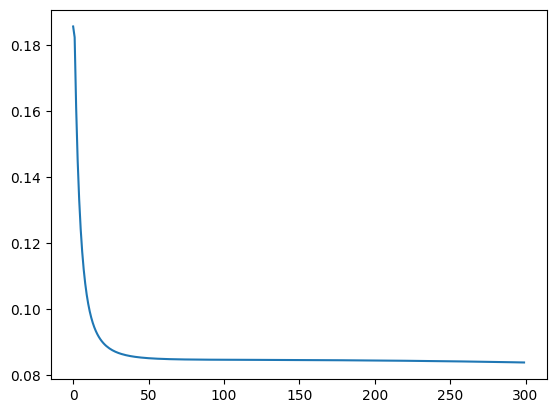

(287, 287)


<ipython-input-316-899ecc063a80>:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


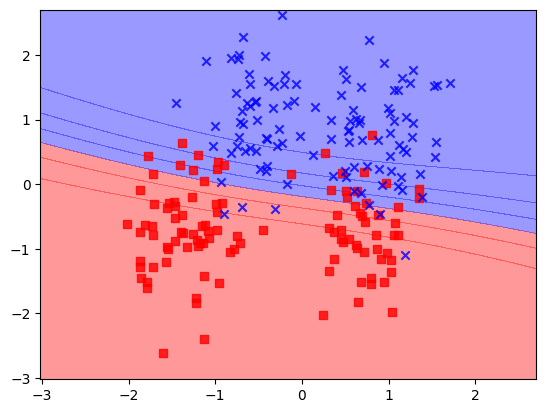

In [ ]:
net = MLP_newton()
net.add(LinearLayer(X_train.shape[2], 64))
net.add(SigmoidLayer())
net.add(LinearLayer(64,2))
net.add(SigmoidLayer())

net.fit(X_train, y_train, epochs=300, learning_rate=0.01)

# test
out = net.predict(X_test)
net.plot_loss_graph()
net.plot_decision_regions(X_test, y_test, classifier=net)


# REGRESSÃO


Antes de testar a regressão, rode novamente a seção da MLP com gradiente


In [ ]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

In [ ]:
X_train, y_train, X_test, y_test = split_train_test(X,y,0.8)
Stdalizer = NormPadronizacao()
Stdalizer.treinar(X_train)

{'media_0': [-0.0022879448933773015], 'desvio_padrao_0': [0.047957739683499596], 'media_1': [-0.0003948618652044522], 'desvio_padrao_1': [0.04753843872766521], 'media_2': [-0.0025525109168930906], 'desvio_padrao_2': [0.04665665093064553], 'media_3': [-0.00197433926948678], 'desvio_padrao_3': [0.04772292842036556], 'media_4': [-0.0016438684285373835], 'desvio_padrao_4': [0.047626147090265455], 'media_5': [-0.002055025361571603], 'desvio_padrao_5': [0.04677371083224853], 'media_6': [0.0023189773935705154], 'desvio_padrao_6': [0.04735629619091889], 'media_7': [-0.002710683933372446], 'desvio_padrao_7': [0.04635315068119044], 'media_8': [-0.0021552497350374486], 'desvio_padrao_8': [0.04777834107613305], 'media_9': [-0.0018610185789160365], 'desvio_padrao_9': [0.04808938885155231]}


In [ ]:
X_train = Stdalizer.normalizar(X_train)
X_test = Stdalizer.normalizar(X_test)

In [ ]:
X_train.shape

(349, 10)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1] )

In [ ]:
net = MLP()
net.add(LinearLayer(X_train.shape[2], 128))
net.add(SigmoidLayer())
net.add(LinearLayer(128,1))


net.fit(X_train, y_train, epochs=200, learning_rate=0.001)

# test
out = net.predict(X_test)



In [ ]:
np.sqrt(mse(y_test, out.reshape(-1))) # RMSE

61.51521416406337

## REG LINEAR


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mse(y_test, y_pred))

# Imprima os resultados
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 52.88510981017927


# TESTE

In [ ]:
net = MLP_newton()
net.add(LinearLayer(X_train.shape[2], 64))
net.add(SigmoidLayer())
net.add(LinearLayer(64,1))

net.fit(X_train, y_train, epochs=100, learning_rate=0.01)

# test
out = net.predict(X_test)

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-313-bf46e689904f>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-u))
Epoch 1:   1%|          | 1/100 [00:00<00:23,  4.25it/s, loss=2.52e+178]<ipython-input-314-e1c7c7d99810>:5: RuntimeWarning: overflow encountered in square
  return np.mean((y_true-y_pred)**2);
<ipython-input-316-899ecc063a80>:77: RuntimeWarning: overflow encountered in double_scalars
  err += mse(y_train[j], output)
<ipython-input-315-546907c3eed6>:9: RuntimeWarning: invalid value encountered in double_scalars
  while mse(y_true,  t * grad) > mse(y_true,y_pred) - alpha * t * new_grad[0][0]:
<ipython-input-313-bf46e689904f>:9: RuntimeWarning: invalid value encountered in multiply
  return self.__derivada_sigmoid(self.input) * output_error
Epoch 99: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s, loss=nan]


In [ ]:
np.sqrt(mse(y_test, out.reshape(-1)))

nan